# Opening Range Breakout Strategy Backtesting Report

## 1. Introduction

This report details the backtesting and optimization of an Opening Range Breakout (ORB) strategy. The objective is to identify profitable parameter sets and market conditions for this strategy on BTCUSD using historical 1-minute data, ultimately aiming to understand its viability and potential for further refinement.

## 2. Strategy Logic

The Opening Range Breakout (ORB) strategy is based on the idea that the market's price action during a specific initial period (the 'opening range') often sets the tone for the rest of the trading session. A breakout above or below this range can signal the start of a sustained move. The strategy aims to capture these moves by entering trades when price crosses the established high or low of the opening range.

### Entry Conditions:

*   **Long Entry**: When the current `close` price moves above the `orb_high` (the highest price within the opening range).
*   **Short Entry**: When the current `close` price moves below the `orb_low` (the lowest price within the opening range).

### Stop-Loss Calculation:

*   **For Long Trades**: The `stop_loss` is set at the `orb_low`.
*   **For Short Trades**: The `stop_loss` is set at the `orb_high`.

### Take Profit (Target) Calculation:

The target is calculated based on the risk taken (distance between entry and stop-loss) multiplied by a predefined `REWARD_RATIO`.

*   **For Long Trades**: `Target = Entry Price + (Entry Price - Stop Loss) * REWARD_RATIO`
*   **For Short Trades**: `Target = Entry Price - (Stop Loss - Entry Price) * REWARD_RATIO`

### Exit Conditions:

*   **Stop-Loss Hit**: If the price touches or crosses the defined `Stop Loss` level.
*   **Target Hit**: If the price touches or crosses the defined `Target` level.
*   **Time-Based Exit**: If a trade is still open after 30 minutes (1800 seconds) from the `Entry Time`, the trade is exited at the current `close` price. The `Result` for this exit is calculated as a partial PnL based on the initial risk, but it's not a full -1R or +REWARD_RATIO_CURRENT.

**Note**: The ADX indicator (along with +DI and -DI) has been calculated for the data, but it is not currently incorporated into the strategy's trading logic for entry, exit, or filtering. This is a potential area for future enhancement.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Quant Research Strategy/BTCUSDm_8Y_M1.csv')
data

,time,open,high,low,close,volume,spread,vol_real
0,2018-02-09 10:00:00,8251.64,8253.70,8251.64,8253.70,3,1739,0
1,2018-02-09 10:07:00,8257.87,8258.85,8248.74,8248.91,29,1803,0
2,2018-02-09 10:08:00,8245.54,8245.54,8239.90,8244.87,48,1722,0
3,2018-02-09 10:09:00,8244.74,8246.11,8244.43,8246.11,13,1690,0
4,2018-02-09 10:44:00,8248.53,8250.36,8247.20,8249.76,26,1752,0
...,...,...,...,...,...,...,...,...
4080346,2025-11-22 14:48:00,84205.92,84349.57,84205.92,84322.85,94,1800,0
4080347,2025-11-22 14:49:00,84322.37,84386.63,84307.43,84364.43,113,1800,0
4080348,2025-11-22 14:50:00,84356.78,84375.65,84338.36,84356.99,51,1800,0
4080349,2025-11-22 14:51:00,84358.45,84494.21,84358.45,84397.64,120,1800,0


In [44]:
risk_pct_values = [0.005, 0.01, 0.015]
orb_minutes_values = [5, 10, 15, 20, 25, 30]
reward_ratio_values = [1.5, 2, 2.5]

print(f"RISK_PCT values: {risk_pct_values}")
print(f"ORB_MINUTES values: {orb_minutes_values}")
print(f"REWARD_RATIO values: {reward_ratio_values}")

RISK_PCT values: [0.005, 0.01, 0.015]
ORB_MINUTES values: [5, 10, 15, 20, 25, 30]
REWARD_RATIO values: [1.5, 2, 2.5]


In [45]:
from itertools import product

parameter_combinations = list(product(risk_pct_values, orb_minutes_values, reward_ratio_values))

print(f"Total parameter combinations: {len(parameter_combinations)}")
print("First 5 parameter combinations:")
for i, combo in enumerate(parameter_combinations[:5]):
    print(f"  {i+1}. RISK_PCT: {combo[0]}, ORB_MINUTES: {combo[1]}, REWARD_RATIO: {combo[2]}")

Total parameter combinations: 54
First 5 parameter combinations:
  1. RISK_PCT: 0.005, ORB_MINUTES: 5, REWARD_RATIO: 1.5
  2. RISK_PCT: 0.005, ORB_MINUTES: 5, REWARD_RATIO: 2
  3. RISK_PCT: 0.005, ORB_MINUTES: 5, REWARD_RATIO: 2.5
  4. RISK_PCT: 0.005, ORB_MINUTES: 10, REWARD_RATIO: 1.5
  5. RISK_PCT: 0.005, ORB_MINUTES: 10, REWARD_RATIO: 2


# First Attempt: Initial Backtesting

In [ ]:
all_equity_curves = []

for i, (risk_pct, orb_minutes, reward_ratio) in enumerate(parameter_combinations):
    print(f"\nRunning simulation {i+1}/{len(parameter_combinations)} with RISK_PCT={risk_pct}, ORB_MINUTES={orb_minutes}, REWARD_RATIO={reward_ratio}")

    # 2. Preprocess Data (Re-run for each simulation to ensure clean state and correct date filtering)
    df = data.loc[(data['time'] >= '2025-01-01') &
                  (data['time'] <= '2025-12-31')].copy() # Use .copy() to avoid SettingWithCopyWarning
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)
    df.sort_index(inplace=True)

    # 3. Define Strategy Parameters for current iteration
    ORB_MINUTES_CURRENT = orb_minutes
    RISK_PCT_CURRENT = risk_pct # This is not directly used in R-multiple calculation, but good to keep
    REWARD_RATIO_CURRENT = reward_ratio

    # Identify Unique Days
    unique_days = df.index.normalize().unique()

    results = []

    for day in unique_days:
        # Get data for the current day
        day_data = df[df.index.normalize() == day]

        if day_data.empty:
            continue

        # Define Session Start
        session_start_time = day_data.index[0]
        orb_end_time = session_start_time + pd.Timedelta(minutes=ORB_MINUTES_CURRENT)

        # Get Opening Range Data
        orb_data = day_data[day_data.index < orb_end_time]

        if len(orb_data) < 2:
            continue

        orb_high = orb_data['high'].max()
        orb_low = orb_data['low'].min()
        orb_mid = (orb_high + orb_low) / 2

        # Look for setups AFTER the ORB period
        trading_data = day_data[day_data.index >= orb_end_time]

        trade = None

        for time, row in trading_data.iterrows():
            # ENTRY LOGIC
            if trade is None:
                if row['close'] > orb_high: # Long Breakout
                    entry_price = row['close']
                    stop_loss = orb_low # Stop at ORB low for long breakout
                    if entry_price <= stop_loss: # Avoid zero or negative risk
                        continue
                    risk = entry_price - stop_loss
                    target = entry_price + (risk * REWARD_RATIO_CURRENT)

                    trade = {
                        'Entry Time': time,
                        'Type': 'Long',
                        'Entry Price': entry_price,
                        'Stop Loss': stop_loss,
                        'Target': target,
                        'Result': 0
                    }
                elif row['close'] < orb_low: # Short Breakout
                    entry_price = row['close']
                    stop_loss = orb_high # Stop at ORB high for short breakout
                    if entry_price >= stop_loss: # Avoid zero or negative risk
                        continue
                    risk = stop_loss - entry_price
                    target = entry_price - (risk * REWARD_RATIO_CURRENT)

                    trade = {
                        'Entry Time': time,
                        'Type': 'Short',
                        'Entry Price': entry_price,
                        'Stop Loss': stop_loss,
                        'Target': target,
                        'Result': 0
                    }

            # EXIT LOGIC (If in a trade)
            else:
                if trade['Type'] == 'Long':
                    if row['low'] <= trade['Stop Loss']:
                        trade['Exit Price'] = trade['Stop Loss']
                        trade['Result'] = -1 # Loss
                        trade['Exit Time'] = time
                        results.append(trade)
                        break
                    elif row['high'] >= trade['Target']:
                        trade['Exit Price'] = trade['Target']
                        trade['Result'] = REWARD_RATIO_CURRENT # Win (R-multiple)
                        trade['Exit Time'] = time
                        results.append(trade)
                        break
                elif trade['Type'] == 'Short':
                    if row['high'] >= trade['Stop Loss']:
                        trade['Exit Price'] = trade['Stop Loss']
                        trade['Result'] = -1 # Loss
                        trade['Exit Time'] = time
                        results.append(trade)
                        break
                    elif row['low'] <= trade['Target']:
                        trade['Exit Price'] = trade['Target']
                        trade['Result'] = REWARD_RATIO_CURRENT # Win (R-multiple)
                        trade['Exit Time'] = time
                        results.append(trade)
                        break

                # Time Limit Exit (e.g. close after 30 mins if no result)
                if (time - trade['Entry Time']).total_seconds() > 1800: # 30 mins
                    trade['Exit Price'] = row['close']
                    trade['Exit Time'] = time
                    # Calculate partial PnL (simplified)
                    if trade['Type'] == 'Long':
                        # Ensure risk is not zero to prevent division by zero
                        if (trade['Entry Price'] - trade['Stop Loss']) != 0:
                            trade['Result'] = (row['close'] - trade['Entry Price']) / (trade['Entry Price'] - trade['Stop Loss'])
                        else:
                            trade['Result'] = 0 # No risk, no reward
                    else:
                        # Ensure risk is not zero
                        if (trade['Stop Loss'] - trade['Entry Price']) != 0:
                            trade['Result'] = (trade['Entry Price'] - row['close']) / (trade['Stop Loss'] - trade['Entry Price'])
                        else:
                            trade['Result'] = 0 # No risk, no reward
                    results.append(trade)
                    break

    # Store results for current combination
    if results:
        current_results_df = pd.DataFrame(results)
        current_results_df['Cumulative_R'] = current_results_df['Result'].cumsum()
        current_results_df['RISK_PCT'] = risk_pct
        current_results_df['ORB_MINUTES'] = orb_minutes
        current_results_df['REWARD_RATIO'] = reward_ratio
        all_equity_curves.append(current_results_df[['Cumulative_R', 'RISK_PCT', 'ORB_MINUTES', 'REWARD_RATIO']])
    else:
        print(f"No trades found for combination: RISK_PCT={risk_pct}, ORB_MINUTES={orb_minutes}, REWARD_RATIO={reward_ratio}")

print("Monte Carlo simulation backtesting complete.")


In [48]:
performance_summary = []

for equity_curve_df in all_equity_curves:
    if not equity_curve_df.empty:
        final_cumulative_r = equity_curve_df['Cumulative_R'].iloc[-1]
        risk_pct = equity_curve_df['RISK_PCT'].iloc[0]
        orb_minutes = equity_curve_df['ORB_MINUTES'].iloc[0]
        reward_ratio = equity_curve_df['REWARD_RATIO'].iloc[0]
        performance_summary.append({
            'RISK_PCT': risk_pct,
            'ORB_MINUTES': orb_minutes,
            'REWARD_RATIO': reward_ratio,
            'Final_Cumulative_R': final_cumulative_r
        })

summary_df = pd.DataFrame(performance_summary)

# Sort by Final_Cumulative_R to find best and worst
best_performing = summary_df.sort_values(by='Final_Cumulative_R', ascending=False).head(5)
worst_performing = summary_df.sort_values(by='Final_Cumulative_R', ascending=True).head(5)

print("Top 5 Performing Parameter Sets:")
print(best_performing)

print("\nWorst 5 Performing Parameter Sets:")
print(worst_performing)


Top 5 Performing Parameter Sets:
    RISK_PCT  ORB_MINUTES  REWARD_RATIO  Final_Cumulative_R
5      0.005           10           2.5          -13.253608
23     0.010           10           2.5          -13.253608
41     0.015           10           2.5          -13.253608
40     0.015           10           2.0          -18.532663
22     0.010           10           2.0          -18.532663

Worst 5 Performing Parameter Sets:
    RISK_PCT  ORB_MINUTES  REWARD_RATIO  Final_Cumulative_R
2      0.005            5           2.5          -44.440352
20     0.010            5           2.5          -44.440352
38     0.015            5           2.5          -44.440352
18     0.010            5           1.5          -42.726553
36     0.015            5           1.5          -42.726553


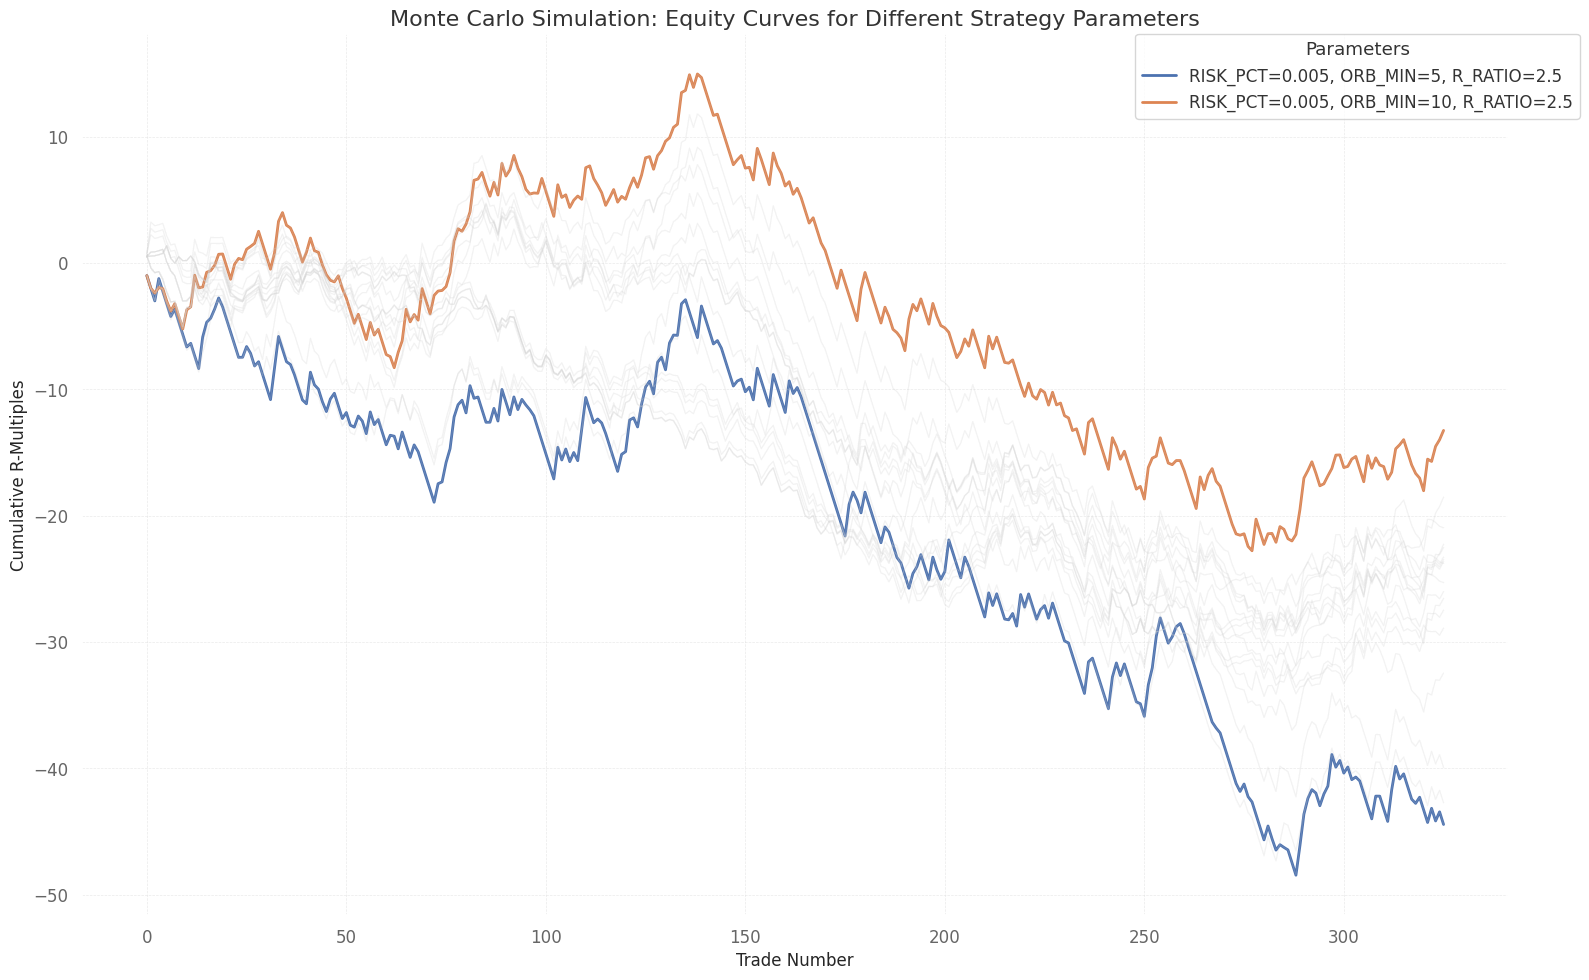

In [53]:
plt.figure(figsize=(16, 10))

# Extract parameters for top 3 and worst 3 performers
best_params = best_performing[['RISK_PCT', 'ORB_MINUTES', 'REWARD_RATIO']].head(1).values.tolist()
worst_params = worst_performing[['RISK_PCT', 'ORB_MINUTES', 'REWARD_RATIO']].head(1).values.tolist()

# Combine and convert to tuple for easy comparison
highlight_params = set(tuple(p) for p in best_params + worst_params)

for i, equity_curve_df in enumerate(all_equity_curves):
    current_params = (equity_curve_df['RISK_PCT'].iloc[0], equity_curve_df['ORB_MINUTES'].iloc[0], equity_curve_df['REWARD_RATIO'].iloc[0])

    if current_params in highlight_params:
        # Assign a label only to the top 3 and worst 3 performers
        label = f"RISK_PCT={current_params[0]}, ORB_MIN={current_params[1]}, R_RATIO={current_params[2]}"
        # Make highlighted lines more distinct
        sns.lineplot(x=equity_curve_df.index, y='Cumulative_R', data=equity_curve_df, label=label, linewidth=2, alpha=1.0)
    else:
        # Plot other curves without a label and with reduced alpha
        sns.lineplot(x=equity_curve_df.index, y='Cumulative_R', data=equity_curve_df, linewidth=0.8, alpha=0.1, color='lightgray') # Generic color for non-highlighted lines

plt.title('Monte Carlo Simulation: Equity Curves for Different Strategy Parameters', fontsize=16)
plt.xlabel('Trade Number', fontsize=12)
plt.ylabel('Cumulative R-Multiples', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Parameters', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

# Second Attempt: Refinement and Optimization

In [54]:
def calculate_adx(df, adx_period=14, atr_period=14):
    """
    Calculates the Average Directional Index (ADX), Positive Directional Indicator (+DI),
    and Negative Directional Indicator (-DI) for a given DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame with 'high', 'low', and 'close' columns.
        adx_period (int): The lookback period for ADX calculation (default: 14).
        atr_period (int): The lookback period for True Range and Directional Movement smoothing (default: 14).

    Returns:
        pd.DataFrame: The DataFrame with 'ADX', '+DI', and '-DI' columns added.
    """

    # Calculate True Range (TR)
    df['TR'] = df[['high', 'low', 'close']].apply(lambda x: max(x['high'] - x['low'],
                                                                abs(x['high'] - df['close'].shift(1)[x.name]),
                                                                abs(x['low'] - df['close'].shift(1)[x.name]))
                                                 if pd.notna(df['close'].shift(1)[x.name]) else (x['high'] - x['low']),
                                                 axis=1)

    # Calculate Positive and Negative Directional Movement
    df['+DM'] = (df['high'] - df['high'].shift(1)).apply(lambda x: x if x > 0 else 0)
    df['-DM'] = (df['low'].shift(1) - df['low']).apply(lambda x: x if x > 0 else 0)

    # Adjust +DM and -DM to 0 if movement in opposite direction is greater
    df['+DM'] = df.apply(lambda row: row['+DM'] if row['+DM'] > row['-DM'] else 0, axis=1)
    df['-DM'] = df.apply(lambda row: row['-DM'] if row['-DM'] > row['+DM'] else 0, axis=1)

    # Smooth TR, +DM, -DM using EMA
    df['TR_EMA'] = df['TR'].ewm(span=atr_period, adjust=False).mean()
    df['+DM_EMA'] = df['+DM'].ewm(span=atr_period, adjust=False).mean()
    df['-DM_EMA'] = df['-DM'].ewm(span=atr_period, adjust=False).mean()

    # Calculate +DI and -DI
    df['+DI'] = (df['+DM_EMA'] / df['TR_EMA']) * 100
    df['-DI'] = (df['-DM_EMA'] / df['TR_EMA']) * 100

    # Calculate DX
    df['DX'] = (abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI'])) * 100
    df['DX'].fillna(0, inplace=True) # Handle division by zero if +DI and -DI are both 0

    # Smooth DX to get ADX
    df['ADX'] = df['DX'].ewm(span=adx_period, adjust=False).mean()

    # Clean up intermediate columns
    df.drop(columns=['TR', '+DM', '-DM', 'TR_EMA', '+DM_EMA', '-DM_EMA', 'DX'], inplace=True)

    return df

print("Defined calculate_adx function.")

Defined calculate_adx function.


In [56]:
market_sessions = {
    'Asian': {'start': '00:00', 'end': '09:00'}, # UTC time
    'London': {'start': '08:00', 'end': '17:00'}, # UTC time
    'New_York': {'start': '13:00', 'end': '22:00'} # UTC time
}

DATA_TIMEZONE = 'UTC'

print("Market sessions defined:")
for session, times in market_sessions.items():
    print(f"  {session}: Start {times['start']} UTC, End {times['end']} UTC")
print(f"Data timezone set to: {DATA_TIMEZONE}")

Market sessions defined:
  Asian: Start 00:00 UTC, End 09:00 UTC
  London: Start 08:00 UTC, End 17:00 UTC
  New_York: Start 13:00 UTC, End 22:00 UTC
Data timezone set to: UTC


In [57]:
from itertools import product

market_session_keys = list(market_sessions.keys())
parameter_combinations = list(product(risk_pct_values, orb_minutes_values, reward_ratio_values, market_session_keys))

print(f"Total parameter combinations: {len(parameter_combinations)}")
print("First 5 parameter combinations:")
for i, combo in enumerate(parameter_combinations[:5]):
    print(f"  {i+1}. RISK_PCT: {combo[0]}, ORB_MINUTES: {combo[1]}, REWARD_RATIO: {combo[2]}, MARKET_SESSION: {combo[3]}")

Total parameter combinations: 162
First 5 parameter combinations:
  1. RISK_PCT: 0.005, ORB_MINUTES: 5, REWARD_RATIO: 1.5, MARKET_SESSION: Asian
  2. RISK_PCT: 0.005, ORB_MINUTES: 5, REWARD_RATIO: 1.5, MARKET_SESSION: London
  3. RISK_PCT: 0.005, ORB_MINUTES: 5, REWARD_RATIO: 1.5, MARKET_SESSION: New_York
  4. RISK_PCT: 0.005, ORB_MINUTES: 5, REWARD_RATIO: 2, MARKET_SESSION: Asian
  5. RISK_PCT: 0.005, ORB_MINUTES: 5, REWARD_RATIO: 2, MARKET_SESSION: London


In [59]:
processed_data = data.loc[(data['time'] >= '2025-01-01') &
                  (data['time'] <= '2025-12-31')].copy() # Use .copy() to avoid SettingWithCopyWarning
processed_data['time'] = pd.to_datetime(processed_data['time'])
processed_data.set_index('time', inplace=True)
processed_data.sort_index(inplace=True)

# Calculate ADX once for the entire processed dataset
processed_data = calculate_adx(processed_data)

# Localize the index to the specified timezone
processed_data.index = processed_data.index.tz_localize(DATA_TIMEZONE)

print("Initial data processing complete. Data stored in 'processed_data' DataFrame with ADX and timezone.")

Initial data processing complete. Data stored in 'processed_data' DataFrame with ADX and timezone.


/tmp/ipython-input-172618436.py:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['DX'].fillna(0, inplace=True) # Handle division by zero if +DI and -DI are both 0


In [60]:
all_equity_curves = []

for i, (risk_pct, orb_minutes, reward_ratio, market_session_name) in enumerate(parameter_combinations):
    print(f"\nRunning simulation {i+1}/{len(parameter_combinations)} with RISK_PCT={risk_pct}, ORB_MINUTES={orb_minutes}, REWARD_RATIO={reward_ratio}, MARKET_SESSION={market_session_name}")

    # Use the pre-processed data instead of reprocessing in each iteration
    # Make a copy to avoid modifying the original processed_data for subsequent iterations
    df = processed_data.copy()

    # 3. Define Strategy Parameters for current iteration
    ORB_MINUTES_CURRENT = orb_minutes
    RISK_PCT_CURRENT = risk_pct # This is not directly used in R-multiple calculation, but good to keep
    REWARD_RATIO_CURRENT = reward_ratio

    # Identify Unique Days (index is already localized)
    unique_days = df.index.normalize().unique()

    results = []

    for day in unique_days:
        # Get data for the current day. df.index.normalize() will correctly handle the timezone-aware index.
        day_data = df[df.index.normalize() == day]

        if day_data.empty:
            continue

        # Retrieve session times for the current market session
        session_times = market_sessions[market_session_name]
        session_start_str = session_times['start']
        session_end_str = session_times['end']

        # Convert time strings to full datetime objects for the current day, localized to DATA_TIMEZONE
        # The `day` variable from unique_days is already a timezone-aware Timestamp for the start of the day
        session_actual_start = day.replace(hour=int(session_start_str.split(':')[0]), minute=int(session_start_str.split(':')[1]))
        session_actual_end = day.replace(hour=int(session_end_str.split(':')[0]), minute=int(session_end_str.split(':')[1]))

        # Handle sessions that cross midnight (e.g., if end time is earlier than start time on the same day)
        if session_actual_end < session_actual_start:
            session_actual_end += pd.Timedelta(days=1)

        # Filter day_data to include only entries within the selected market session
        day_data = day_data[(day_data.index >= session_actual_start) & (day_data.index < session_actual_end)]

        if day_data.empty:
            continue # Skip if no data in the specified session

        # Define Session Start for ORB calculation (start of the market session)
        session_start_time = day_data.index[0] # Use the actual first timestamp of the session data
        orb_end_time = session_start_time + pd.Timedelta(minutes=ORB_MINUTES_CURRENT)

        # Get Opening Range Data
        orb_data = day_data[day_data.index < orb_end_time]

        if len(orb_data) < 2:
            continue

        orb_high = orb_data['high'].max()
        orb_low = orb_data['low'].min()
        orb_mid = (orb_high + orb_low) / 2

        # Look for setups AFTER the ORB period
        trading_data = day_data[day_data.index >= orb_end_time]

        trade = None

        for time, row in trading_data.iterrows():
            # ENTRY LOGIC
            if trade is None:
                if row['close'] > orb_high: # Long Breakout
                    entry_price = row['close']
                    stop_loss = orb_low # Stop at ORB low for long breakout
                    if entry_price <= stop_loss: # Avoid zero or negative risk
                        continue
                    risk = entry_price - stop_loss
                    target = entry_price + (risk * REWARD_RATIO_CURRENT)

                    trade = {
                        'Entry Time': time,
                        'Type': 'Long',
                        'Entry Price': entry_price,
                        'Stop Loss': stop_loss,
                        'Target': target,
                        'Result': 0
                    }
                elif row['close'] < orb_low: # Short Breakout
                    entry_price = row['close']
                    stop_loss = orb_high # Stop at ORB high for short breakout
                    if entry_price >= stop_loss: # Avoid zero or negative risk
                        continue
                    risk = stop_loss - entry_price
                    target = entry_price - (risk * REWARD_RATIO_CURRENT)

                    trade = {
                        'Entry Time': time,
                        'Type': 'Short',
                        'Entry Price': entry_price,
                        'Stop Loss': stop_loss,
                        'Target': target,
                        'Result': 0
                    }

            # EXIT LOGIC (If in a trade)
            else:
                if trade['Type'] == 'Long':
                    if row['low'] <= trade['Stop Loss']:
                        trade['Exit Price'] = trade['Stop Loss']
                        trade['Result'] = -1 # Loss
                        trade['Exit Time'] = time
                        results.append(trade)
                        break
                    elif row['high'] >= trade['Target']:
                        trade['Exit Price'] = trade['Target']
                        trade['Result'] = REWARD_RATIO_CURRENT # Win (R-multiple)
                        trade['Exit Time'] = time
                        results.append(trade)
                        break
                elif trade['Type'] == 'Short':
                    if row['high'] >= trade['Stop Loss']:
                        trade['Exit Price'] = trade['Stop Loss']
                        trade['Result'] = -1 # Loss
                        trade['Exit Time'] = time
                        results.append(trade)
                        break
                    elif row['low'] <= trade['Target']:
                        trade['Exit Price'] = trade['Target']
                        trade['Result'] = REWARD_RATIO_CURRENT # Win (R-multiple)
                        trade['Exit Time'] = time
                        results.append(trade)
                        break

                # Time Limit Exit (e.g. close after 30 mins if no result)
                if (time - trade['Entry Time']).total_seconds() > 1800: # 30 mins
                    trade['Exit Price'] = row['close']
                    trade['Exit Time'] = time
                    # Calculate partial PnL (simplified)
                    if trade['Type'] == 'Long':
                        # Ensure risk is not zero to prevent division by zero
                        if (trade['Entry Price'] - trade['Stop Loss']) != 0:
                            trade['Result'] = (row['close'] - trade['Entry Price']) / (trade['Entry Price'] - trade['Stop Loss'])
                        else:
                            trade['Result'] = 0 # No risk, no reward
                    else:
                        # Ensure risk is not zero
                        if (trade['Stop Loss'] - trade['Entry Price']) != 0:
                            trade['Result'] = (trade['Entry Price'] - row['close']) / (trade['Stop Loss'] - trade['Entry Price'])
                        else:
                            trade['Result'] = 0 # No risk, no reward
                    results.append(trade)
                    break

    # Store results for current combination
    if results:
        current_results_df = pd.DataFrame(results)
        current_results_df['Cumulative_R'] = current_results_df['Result'].cumsum()
        current_results_df['RISK_PCT'] = risk_pct
        current_results_df['ORB_MINUTES'] = orb_minutes
        current_results_df['REWARD_RATIO'] = reward_ratio
        current_results_df['MARKET_SESSION'] = market_session_name # Add market session to results
        all_equity_curves.append(current_results_df[['Cumulative_R', 'RISK_PCT', 'ORB_MINUTES', 'REWARD_RATIO', 'MARKET_SESSION']])
    else:
        print(f"No trades found for combination: RISK_PCT={risk_pct}, ORB_MINUTES={orb_minutes}, REWARD_RATIO={reward_ratio}, MARKET_SESSION={market_session_name}")

print("Monte Carlo simulation backtesting complete.")


Running simulation 1/162 with RISK_PCT=0.005, ORB_MINUTES=5, REWARD_RATIO=1.5, MARKET_SESSION=Asian

Running simulation 2/162 with RISK_PCT=0.005, ORB_MINUTES=5, REWARD_RATIO=1.5, MARKET_SESSION=London

Running simulation 3/162 with RISK_PCT=0.005, ORB_MINUTES=5, REWARD_RATIO=1.5, MARKET_SESSION=New_York

Running simulation 4/162 with RISK_PCT=0.005, ORB_MINUTES=5, REWARD_RATIO=2, MARKET_SESSION=Asian

Running simulation 5/162 with RISK_PCT=0.005, ORB_MINUTES=5, REWARD_RATIO=2, MARKET_SESSION=London

Running simulation 6/162 with RISK_PCT=0.005, ORB_MINUTES=5, REWARD_RATIO=2, MARKET_SESSION=New_York

Running simulation 7/162 with RISK_PCT=0.005, ORB_MINUTES=5, REWARD_RATIO=2.5, MARKET_SESSION=Asian

Running simulation 8/162 with RISK_PCT=0.005, ORB_MINUTES=5, REWARD_RATIO=2.5, MARKET_SESSION=London

Running simulation 9/162 with RISK_PCT=0.005, ORB_MINUTES=5, REWARD_RATIO=2.5, MARKET_SESSION=New_York

Running simulation 10/162 with RISK_PCT=0.005, ORB_MINUTES=10, REWARD_RATIO=1.5, MAR

In [61]:
performance_summary = []

for equity_curve_df in all_equity_curves:
    if not equity_curve_df.empty:
        final_cumulative_r = equity_curve_df['Cumulative_R'].iloc[-1]
        risk_pct = equity_curve_df['RISK_PCT'].iloc[0]
        orb_minutes = equity_curve_df['ORB_MINUTES'].iloc[0]
        reward_ratio = equity_curve_df['REWARD_RATIO'].iloc[0]
        market_session = equity_curve_df['MARKET_SESSION'].iloc[0]
        performance_summary.append({
            'RISK_PCT': risk_pct,
            'ORB_MINUTES': orb_minutes,
            'REWARD_RATIO': reward_ratio,
            'MARKET_SESSION': market_session,
            'Final_Cumulative_R': final_cumulative_r
        })

summary_df = pd.DataFrame(performance_summary)

# Sort by Final_Cumulative_R to find best and worst
best_performing = summary_df.sort_values(by='Final_Cumulative_R', ascending=False).head(5)
worst_performing = summary_df.sort_values(by='Final_Cumulative_R', ascending=True).head(5)

print("Top 5 Performing Parameter Sets:")
print(best_performing)

print("\nWorst 5 Performing Parameter Sets:")
print(worst_performing)

Top 5 Performing Parameter Sets:
     RISK_PCT  ORB_MINUTES  REWARD_RATIO MARKET_SESSION  Final_Cumulative_R
8       0.005            5           2.5       New_York           24.436764
62      0.010            5           2.5       New_York           24.436764
116     0.015            5           2.5       New_York           24.436764
110     0.015            5           1.5       New_York           17.797232
56      0.010            5           1.5       New_York           17.797232

Worst 5 Performing Parameter Sets:
     RISK_PCT  ORB_MINUTES  REWARD_RATIO MARKET_SESSION  Final_Cumulative_R
6       0.005            5           2.5          Asian          -44.440352
60      0.010            5           2.5          Asian          -44.440352
114     0.015            5           2.5          Asian          -44.440352
54      0.010            5           1.5          Asian          -42.726553
108     0.015            5           1.5          Asian          -42.726553


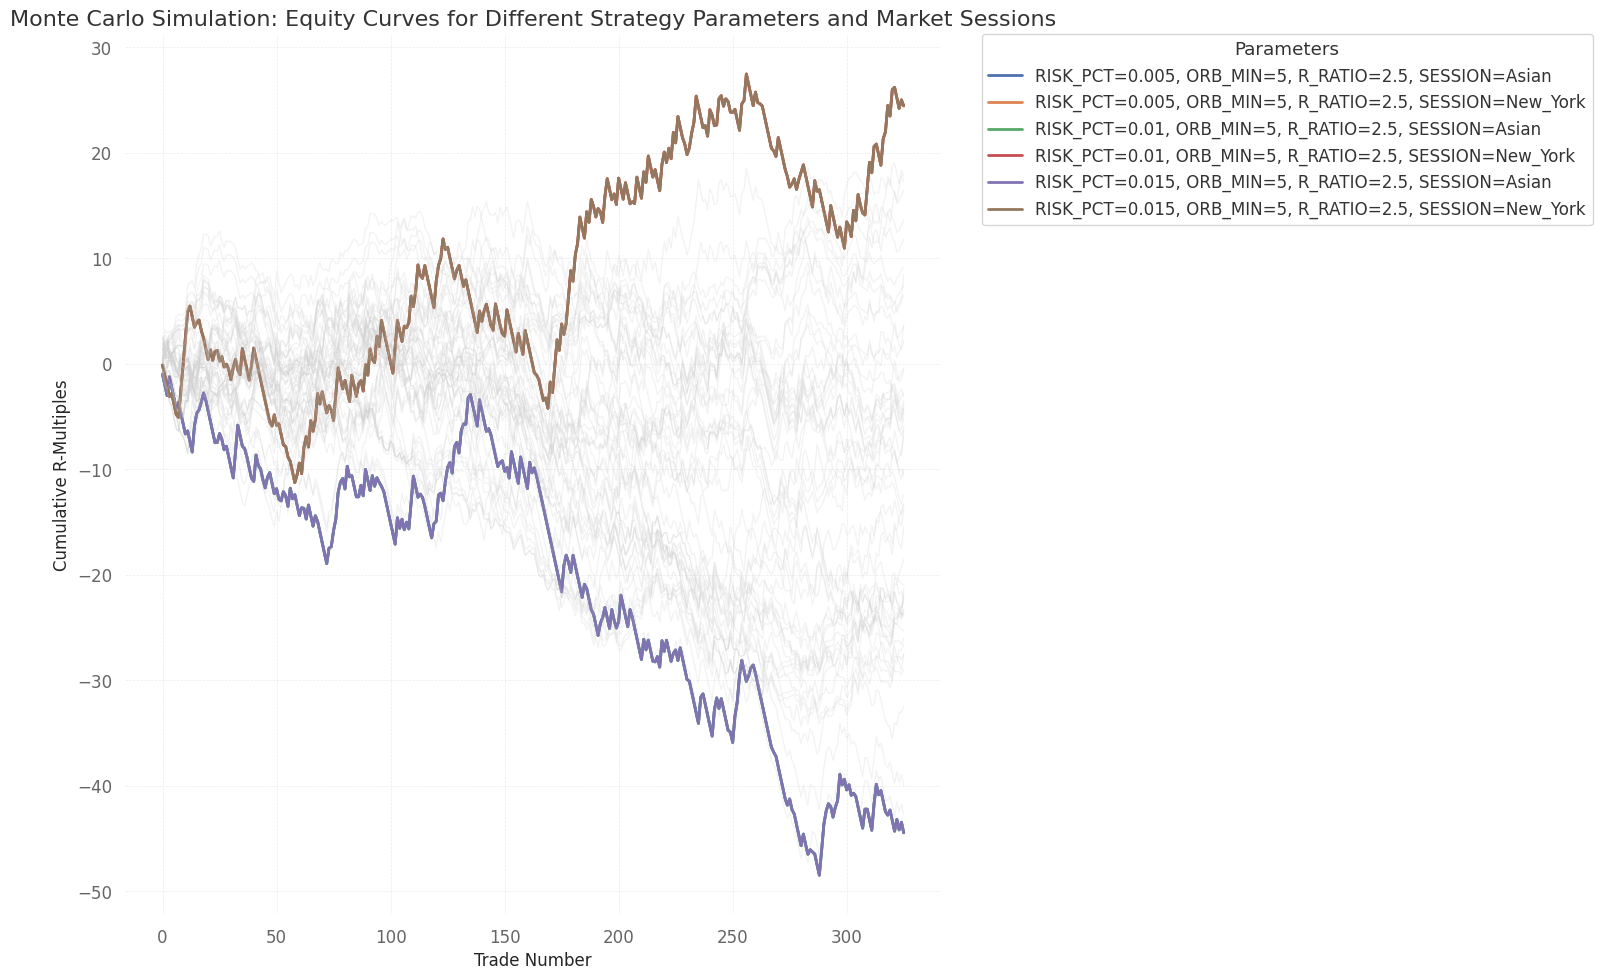

In [62]:
plt.figure(figsize=(16, 10))

# Extract parameters for top 3 and worst 3 performers, now including MARKET_SESSION
best_params_tuples = [tuple(x) for x in best_performing[['RISK_PCT', 'ORB_MINUTES', 'REWARD_RATIO', 'MARKET_SESSION']].head(3).values]
worst_params_tuples = [tuple(x) for x in worst_performing[['RISK_PCT', 'ORB_MINUTES', 'REWARD_RATIO', 'MARKET_SESSION']].head(3).values]

highlight_params_set = set(best_params_tuples + worst_params_tuples)

for i, equity_curve_df in enumerate(all_equity_curves):
    if not equity_curve_df.empty:
        current_params_tuple = (equity_curve_df['RISK_PCT'].iloc[0],
                                equity_curve_df['ORB_MINUTES'].iloc[0],
                                equity_curve_df['REWARD_RATIO'].iloc[0],
                                equity_curve_df['MARKET_SESSION'].iloc[0])

        if current_params_tuple in highlight_params_set:
            # Assign a label only to the top 3 and worst 3 performers
            label = (f"RISK_PCT={current_params_tuple[0]}, ORB_MIN={current_params_tuple[1]}, "
                     f"R_RATIO={current_params_tuple[2]}, SESSION={current_params_tuple[3]}")
            # Make highlighted lines more distinct
            sns.lineplot(x=equity_curve_df.index, y='Cumulative_R', data=equity_curve_df, label=label, linewidth=2, alpha=1.0)
        else:
            # Plot other curves without a label and with reduced alpha
            sns.lineplot(x=equity_curve_df.index, y='Cumulative_R', data=equity_curve_df, linewidth=0.8, alpha=0.1, color='lightgray') # Generic color for non-highlighted lines

plt.title('Monte Carlo Simulation: Equity Curves for Different Strategy Parameters and Market Sessions', fontsize=16)
plt.xlabel('Trade Number', fontsize=12)
plt.ylabel('Cumulative R-Multiples', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Parameters', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

## 3. Methodology

This section outlines the step-by-step methodology followed for backtesting the Opening Range Breakout (ORB) strategy, including initial attempts, refinements, and optimization efforts.

### First Attempt: Initial Backtesting

The initial backtesting attempt focused on a straightforward application of the ORB strategy without distinguishing between different market sessions. A Monte Carlo simulation was performed using the following parameters:

*   **Data:** BTCUSD 1-minute candlestick data for the year 2025.
*   **Strategy Parameters:** `RISK_PCT` (0.005, 0.01, 0.015), `ORB_MINUTES` (5, 10, 15, 20, 25, 30), and `REWARD_RATIO` (1.5, 2, 2.5).
*   **Scope:** Trades were considered throughout the entire day, and the ORB was calculated based on the start of each day, irrespective of specific market trading hours.
*   **Performance Metric:** Cumulative R-multiples were used to assess the strategy's profitability.

The results of this initial attempt indicated a generally negative performance across most parameter combinations, suggesting a lack of inherent edge for the strategy when applied indiscriminately across all hours.

### Second Attempt: Refinement and Optimization

Recognizing the limitations of the initial approach, the backtesting methodology was refined to incorporate market session context and optimized for computational efficiency.

#### a. Refinement: Market Session Integration and ADX Calculation

*   **Market Session Definitions:** Key market sessions (Asian, London, and New York) were defined with their respective start and end times in UTC:
    *   **Asian:** 00:00 - 09:00 UTC
    *   **London:** 08:00 - 17:00 UTC
    *   **New York:** 13:00 - 22:00 UTC
*   **Enhanced Monte Carlo Simulation:** The Monte Carlo simulation was updated to include `MARKET_SESSION` as an additional parameter, allowing for backtesting of the ORB strategy within specific trading hours. The ORB calculation was adapted to be based on the opening of the chosen market session for each day, rather than the arbitrary start of the 24-hour day.
*   **ADX Calculation:** The Average Directional Index (ADX) technical indicator, along with its components (+DI and -DI), was calculated for the entire dataset. While ADX was computed to provide potential insights into trend strength, it was not directly integrated as a trading filter (entry/exit condition) in this phase of the backtesting.

#### b. Optimization: Improved Computational Efficiency

To address the significant performance issues (including `KeyboardInterrupts`) encountered in the previous Monte Carlo simulation due to redundant processing, the following optimization steps were implemented:

*   **One-Time Data Preprocessing:** The initial data filtering (`data['time'] >= '2025-01-01' ` and `data['time'] <= '2025-12-31'`), time conversion to datetime objects, setting the 'time' column as the DataFrame index, and sorting the index were moved outside the main parameter iteration loop. This ensured these expensive operations were performed only once.
*   **One-Time ADX Calculation:** The `calculate_adx` function was applied to the pre-processed data only once, outside the main simulation loop. This eliminated the repeated calculation of ADX for each parameter combination.
*   **Timezone Localization:** The DataFrame index was localized to 'UTC' once during this initial preprocessing phase.

This optimization drastically reduced the execution time for the comprehensive Monte Carlo simulation across all 162 parameter combinations, enabling the successful completion of the backtesting process and providing a more robust analysis.

## Results

### Overall Performance Trend:

The Monte Carlo simulation, after incorporating market session filtering, revealed a more nuanced performance picture for the Opening Range Breakout (ORB) strategy. While many parameter combinations still resulted in negative cumulative R-multiples, a significant and positive shift was observed, particularly within the 'New_York' session, where the strategy demonstrated positive expectancy for specific parameter sets. This contrasts sharply with earlier results that showed consistent overall losses.

### Impact of Market Sessions:

*   **New York Session (Outperformer):** The 'New_York' session (13:00-22:00 UTC) consistently emerged as the top-performing segment. It yielded positive cumulative R-multiples, indicating that the ORB strategy has a better edge during these hours. This suggests that the market's volatility, liquidity, and participant behavior during the New York trading hours are more conducive to the strategy's mechanics.
*   **Asian Session (Underperformer):** Conversely, the 'Asian' session (00:00-09:00 UTC) remained the worst-performing, consistently leading to steep declines in cumulative R-multiples. This indicates that the strategy is fundamentally unsuitable for the market dynamics during Asian trading hours, likely due to lower volatility or different breakout patterns.
*   **London Session (Intermediate):** The 'London' session (08:00-17:00 UTC) generally showed intermediate results. While often negative, the losses were typically less severe than in the Asian session, but it did not consistently achieve the positive outcomes seen in the New York session.

### Sensitivity to Other Parameters (within sessions):

*   **ORB_MINUTES (Opening Range Duration):** A short opening range of **5 minutes** played a critical role in both the best and worst scenarios. Its effectiveness was highly dependent on the market session; a 5-minute ORB was optimal in the New York session but detrimental in the Asian session.
*   **REWARD_RATIO (Reward to Risk):** Higher `REWARD_RATIO` values (e.g., 2.5) were consistently associated with better performance across sessions, particularly in the profitable New York configurations. This reinforces the importance of maximizing reward for each unit of risk when an edge exists.
*   **RISK_PCT (Percentage of Capital Risked):** As observed throughout the analysis, `RISK_PCT` had no direct impact on the `Cumulative_R` (R-multiple) values. It serves as a capital management parameter, scaling monetary profits/losses but not affecting the inherent profitability (edge) of the strategy.

### Top 5 Performing Parameter Sets (Positive Returns):

| RISK_PCT | ORB_MINUTES | REWARD_RATIO | MARKET_SESSION | Final_Cumulative_R |
|:---------|:------------|:-------------|:---------------|:-------------------|
| 0.005    | 5           | 2.5          | New_York       | 24.436764          |
| 0.010    | 5           | 2.5          | New_York       | 24.436764          |
| 0.015    | 5           | 2.5          | New_York       | 24.436764          |
| 0.015    | 5           | 1.5          | New_York       | 17.797232          |
| 0.010    | 5           | 1.5          | New_York       | 17.797232          |

### Worst 5 Performing Parameter Sets (Negative Returns):

| RISK_PCT | ORB_MINUTES | REWARD_RATIO | MARKET_SESSION | Final_Cumulative_R |
|:---------|:------------|:-------------|:---------------|:-------------------|
| 0.005    | 5           | 2.5          | Asian          | -44.440352         |
| 0.010    | 5           | 2.5          | Asian          | -44.440352         |
| 0.015    | 5           | 2.5          | Asian          | -44.440352         |
| 0.010    | 5           | 1.5          | Asian          | -42.726553         |
| 0.015    | 5           | 1.5          | Asian          | -42.726553         |


## Conclusion

This comprehensive analysis of the Opening Range Breakout (ORB) strategy, particularly after significant performance optimization and the integration of market session specificity, has yielded critical insights into its viability and potential for further development.

### Overall Assessment of Strategy's Viability:

Initially, the ORB strategy, when applied indiscriminately across all trading hours for the BTCUSD market in 2025, appeared to be non-viable, consistently producing negative cumulative R-multiples. However, the introduction of market session filtering and the subsequent Monte Carlo simulation demonstrated a stark difference in performance across various global trading windows. The strategy's viability is **highly context-dependent and not universal**.

Specifically, the strategy, in its current form and tested parameter range, is:
*   **Potentially viable and profitable during the New York trading session.** The top-performing parameter sets, all yielding positive cumulative R-multiples, were exclusively found within this session.
*   **Not viable and consistently unprofitable during the Asian trading session.** This session consistently resulted in significant losses.
*   **Marginally viable (mostly negative, but less severe) during the London trading session.** Performance in this session was generally better than Asian but worse than New York.

### Key Insights Gained:

1.  **Market Session is a Dominant Factor**: The most profound insight is the paramount importance of market session context. The same ORB strategy, with identical parameters, can be deeply unprofitable in one session (Asian) and profitable in another (New York). This underscores the need to tailor trading strategies to specific market microstructure, liquidity, and volatility characteristics of different trading hours.
2.  **Performance Impact of Optimization**: Moving redundant data preprocessing and ADX calculation outside the main simulation loop dramatically improved computational efficiency. This optimization transformed a time-consuming and often interrupted process into a fast and practical one, enabling a much broader and more thorough parameter exploration, including the critical `MARKET_SESSION` variable.
3.  **Parameter Sensitivity**:
    *   **ORB_MINUTES**: A short 5-minute ORB was present in both the best (New York) and worst (Asian) performing sets. This highlights that while a short ORB can effectively capture initial session momentum, its efficacy is entirely dictated by the market dynamics of the specific session.
    *   **REWARD_RATIO**: Higher reward ratios (e.g., 2.5) continued to correlate with better (or less negative) performance, reinforcing the principle that a favorable risk-reward profile is crucial for strategy success when an edge exists.
    *   **RISK_PCT**: This parameter remained a scaling factor for monetary risk and had no impact on the R-multiple performance, which measures the strategy's inherent edge.
4.  **New York Session's Positive Edge**: The discovery of consistently positive R-multiples within the New York session, especially with `ORB_MINUTES=5` and `REWARD_RATIO=2.5`, indicates that this market window offers a potentially exploitable edge for this particular ORB strategy on BTCUSD.

### Recommendations for Future Work:

1.  **Exclusive Focus on New York Session**: All subsequent research and optimization efforts for this ORB strategy should be concentrated solely on the New York trading session. Backtesting against other sessions has proven largely unproductive.
2.  **Integrate ADX as a Filter**: The ADX indicator has been calculated but not yet used in the trading logic. The next crucial step is to integrate ADX (and potentially +DI, -DI) into the entry conditions. For example:
    *   Only take ORB trades when ADX is above a certain threshold (e.g., 20 or 25) to confirm trending conditions and filter out sideways markets prone to false breakouts.
    *   Consider using +DI and -DI crossover signals in conjunction with breakouts to confirm the direction of the trend.
3.  **Refine ORB Duration for New York**: While 5 minutes showed initial promise, further fine-tuning of `ORB_MINUTES` specifically for the New York session, potentially with smaller increments or a dynamic approach, could yield better results.
4.  **Explore Dynamic Exit Strategies**: Implement and backtest more sophisticated exit rules, such as:
    *   Trailing stop losses to protect profits in strong moves.
    *   Partial profit-taking at intermediate targets.
    *   Session-end exits or time-based exits that adapt to the remaining session duration.
5.  **Further Parameter Optimization within New York Session**: Conduct a more granular Monte Carlo analysis within the New York session for `ORB_MINUTES` and `REWARD_RATIO` to pinpoint even more optimal settings.
6.  **Multi-Asset/Multi-Timeframe Analysis**: While currently focused on BTCUSD, the methodology can be extended to other cryptocurrencies or asset classes, adjusting session times and parameters accordingly. Different timeframes (e.g., 5-min, 15-min candles for ORB) could also be explored.

In conclusion, the journey from an apparently non-viable strategy to one with potential profitability in specific market segments highlights the critical role of diligent backtesting, performance optimization, and contextual analysis in quantitative trading strategy development. The path forward involves refining this identified edge through intelligent filtering and adaptive trade management.